<div class="markdown-google-sans">

# **3. NOAA Tides and Currents in CSV or txt format**
</div>

[NOAA Tides and Currents](https://tidesandcurrents.noaa.gov/)


![picture](https://drive.google.com/uc?export=view&id=1pHqhY95KimS9UXmtrEuL_GHGr_9LzeMq)



"NOAA's Center for Operational Oceanographic Products and Services (CO-OPS) is the authoritative source for accurate, reliable, and timely tides, water levels, currents, and other coastal oceanographic and meteorological information. Our services support safe and efficient maritime commerce and transportation, help protect public health and safety, and promote robust, resilient coastal communities. CO-OPS maintains ocean observing infrastructure, including more than 200 permanent water level stations on the U.S. coasts and Great Lakes, an integrated system of real-time sensors concentrated in busy seaports, and temporary meters that collect observations for tidal current predictions. Through these systems, we provide the nation with historic and real-time data, forecasts, predictions, and scientific analyses that protect life, the economy, and the environment on the coast."

We can use the pylib package by Dr. Zhengui Wang for data manipulatin, analysis and visualization.

**npz_data:**
This is the self-defined data structure by Zhengui Wang. Attributes are used to store data.

In [ ]:
!pip install git+https://github.com/wzhengui/pylibs.git
from pylib import *
import numpy as np
from numpy import *
import urllib.request

  Cloning https://github.com/wzhengui/pylibs.git to /tmp/pip-req-build-_c___g7d
  Running command git clone --filter=blob:none --quiet https://github.com/wzhengui/pylibs.git /tmp/pip-req-build-_c___g7d
  Resolved https://github.com/wzhengui/pylibs.git to commit b35b37a94f55568d93371a31f113e5f07fb63497
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
  Created wheel for pylibs-ocean: filename=pylibs_ocean-1.0.1-py3-none-any.whl size=388600 sha256=2b721216d5b0ea0043810037f419875fc27ac2d772194e3ee003da3229d42000
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rh13s9m/wheels/20/52/e1/8379a0fe3ac5ef568126f951b46e7f2e16eeef51057a0429ef
Successfully built pylibs-ocean


##**2.1 Download sea level data for two different datums**

###***Save a 2D array to txt file***

In [ ]:
# download water level data
# The raw data have not been subjected to the National Ocean Service's quality control or quality assurance procedures and do not meet the criteria and standards of official National Ocean Service data. They are released for limited public use as preliminary data to be used only with appropriate caution.

#input
years=[2018,2019]

#a datum is a base elevation used as a reference from which to reckon heights or depths.
#navd: North American Vertical Datum of 1988 (NAVD88); a fixed reference for elevations determined by geodetic leveling.
datums=['navd','msl'] # navd and msl are two different datums. navd is nvad88

# two stations with longitude and latitudes as below:
stations = np.array([[-75.705, 35.20833,8654467],[-77.95333, 34.22667, 8658120]])
print(stations)
np.savetxt('stations.txt',stations,fmt='%7.4f, %7.4f, %d')

[[-7.570500e+01  3.520833e+01  8.654467e+06]
 [-7.795333e+01  3.422667e+01  8.658120e+06]]


In [ ]:
!ls

sample_data  stations.txt


###***Create an npz data capsule***

In [ ]:
from matplotlib import dates
C = npz_data(); C.lon=stations[:,0]; C.lat=stations[:,1]; C.station=stations[:,2]
print(type(C))
print(C.VINFO)

<class 'pyUtility.mylib.zdata'>
['lon   : array(2,), float64', 'lat   : array(2,), float64', 'station: array(2,), float64']


In [ ]:
## Copyright of Dr. Zhengui Wang

#noaa web link
url0='https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv'

#download and read noaa data
for datum in datums:
    print(datum)
    if not os.path.exists(datum): os.mkdir(datum)
    #download data
    for m,station in enumerate(C.station):
        for year in arange(years[0],years[1]+1):
            url='{}&datum={}&begin_date={}0101&end_date={}1231&station={}'.format(url0,datum.upper(),year,year,int(station))

            print(url);
            fname='{}_{}.csv'.format(int(station),year)
            print(fname)

            if os.path.exists('{}/{}'.format(datum,fname)): continue
            print('download: {}, {}'.format(datum,fname))
            # the try block lets you test a block of code for errors
            # the except block lets you handle the error
            try:
                urllib.request.urlretrieve(url,'{}/{}'.format(datum,fname))
            except:
                # the pass statement is a null statement, a placeholder for future code
                pass

#read data
    fnames=os.listdir('{}'.format(datum));
    #read each file in years
    mtime=[]; station=[]; elev=[]; iflag=0
    for fname in fnames:
        if not fname.endswith('.csv'): continue
        # A RegularExpression (RE) is a special text string used for describing a search pattern
        R=re.match('(\d+)_(\d+).csv',fname); sta=int(R.groups()[0]); year=int(R.groups()[1])

        #read data
        iflag=iflag+1; print('reading {}, {}'.format(fname,iflag))
        fid=open('{}/{}'.format(datum,fname),'r'); lines=fid.readlines(); fid.close(); lines=lines[1:]
        if len(lines)<10: continue

        #parse each line
        for i in arange(len(lines)):
            line=lines[i].split(',')
            if line[1]=='': continue
            #print(line[0])
            doyi=dates.datestr2num(line[0]); elevi=float(line[1])

            #save record
            mtime.append(doyi)
            station.append(sta)
            elev.append(elevi)
#-save data-------
    S=npz_data(); S.time=array(mtime); S.elev=array(elev)
    S.station=array(station).astype('int')

    # add lat&lon information
    Lat=dict(zip(C.station,C.lat)); Lon=dict(zip(C.station,C.lon))
    S.lat=array([Lat[i] for i in S.station])
    S.lon=array([Lon[i] for i in S.station])
    save_npz('noaa_elev_{}'.format(datum),S)

navd
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv&datum=NAVD&begin_date=20180101&end_date=20181231&station=8654467
8654467_2018.csv
download: navd, 8654467_2018.csv
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv&datum=NAVD&begin_date=20190101&end_date=20191231&station=8654467
8654467_2019.csv
download: navd, 8654467_2019.csv
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv&datum=NAVD&begin_date=20180101&end_date=20181231&station=8658120
8658120_2018.csv
download: navd, 8658120_2018.csv
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv&datum=NAVD&begin_date=20190101&end_date=20191231&station=86581

In [ ]:
!ls

msl  navd  noaa_elev_msl.npz  noaa_elev_navd.npz  sample_data  stations.txt


##**2.2 Data reading and visualization**

In [ ]:
msl=loadz('noaa_elev_msl.npz')
print(msl.VINFO)

['elev  : array(35040,), float64', 'lat   : array(35040,), float64', 'lon   : array(35040,), float64', 'station: array(35040,), int64', 'time  : array(35040,), float64']


In [ ]:
#get data at noaa station 8654467
fp=(msl.station==8654467)*(msl.time>=datenum(2018,2,1))*(msl.time<datenum(2018,3,1))
oti,oyi=msl.time[fp],msl.elev[fp]

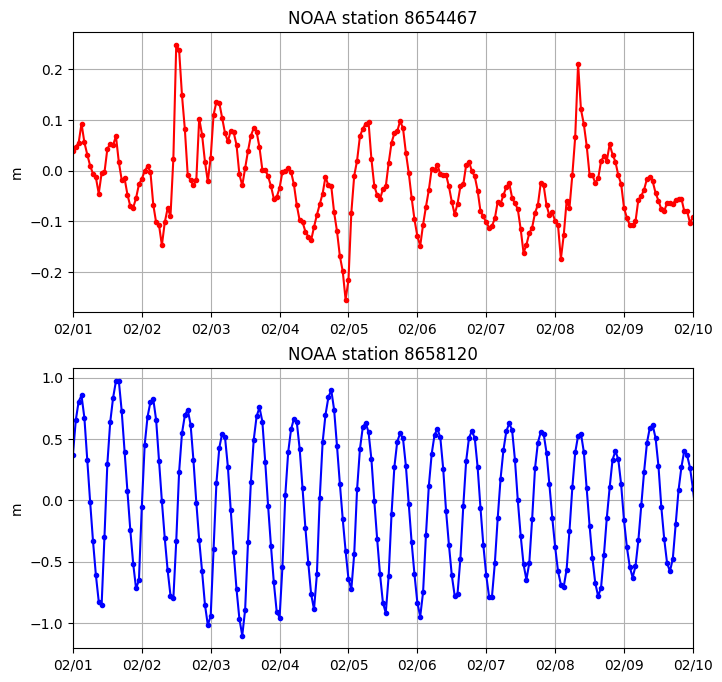

In [ ]:
#plot elevation data
figure(figsize=[8,8])
#xts,xls=get_xtick(fmt=2,xts=[datenum(2018,2,1),datenum(2018,3,1)],str='%Y-%m-%d')
xts,xls=get_xtick(fmt=2,xts=[datenum(2018,2,1),datenum(2018,3,1)],str=4)

subplot(2,1,1)
plot(oti,oyi,'r.-')
setp(gca(),xticks=xts,xticklabels=xls,xlim=[datenum(2018,2,1),datenum(2018,2,10)]);
title('NOAA station 8654467')
ylabel('m')
grid('on')

#get data at noaa station 8658120
fp=(msl.station==8658120)*(msl.time>=datenum(2018,2,1))*(msl.time<datenum(2018,3,1))
oti,oyi=msl.time[fp],msl.elev[fp]
subplot(2,1,2)
plot(oti,oyi,'b.-')
setp(gca(),xticks=xts,xticklabels=xls,xlim=[datenum(2018,2,1),datenum(2018,2,10)]);
title('NOAA station 8658120')
ylabel('m')
grid('on')


# ##**2.3 Harmonic Analysis**

Since we are looking at sea level elevations, let's talk about Harmonic Analysis.

The periodic nature of the sea level elevation  implies a strong tidal component. Although other periodic components exist like wind forcing of the water due to a sea breeze, but no other periodic trends occur at the scale of tides in terms of consistency. To identify the tidal signal, we use sines and cosines (sinusoidal functions).

y = sin(x)

It is periodic, but not as what we observed. We can do better by adding periodic functions. Any periodic function can be modeled as the summation of sins and consines through Fourier Transform.

We can break down the tides to summation of sines and cosines, each periodic function is corresponding to one harmonic constituent.

"Tides are created by the gravitational forces of the Moon and Sun, acting upon the waters of the Earth. Those gravitational forces change as the relative positions of the Earth, Sun, and Moon change."

"There are hundreds of periodic motions of the Earth, Sun, and Moon that are identified by astronomy. Each of these motions or “constituents” in a set of harmonic constants is a mathematical value describing the effect that cyclical motion of the Earth, Sun, Moon system has on the tides. There are **37** which normally have the greatest effect on tides and are used as the tidal harmonic constituents to predict tidal conditions for a location."



1.   M2: the largest lunar constituent, period of 12 hours and 25 minutes
2.   S2: the largest solar constituent, period of 12 hours


Pawlowicz et al (2002) wrote the progra 'T_TIDE' package for classical tidal harmonic analysis and error estimation of harmonic constant using the LSE.

Codiga, D.L., 2011. Unified Tidal Analysis and Prediction Using the
UTide Matlab Functions. Technical Report 2011-01. Graduate School
of Oceanography, University of Rhode Island, Narragansett, RI.
59pp. ftp://www.po.gso.uri.edu/pub/downloads/codiga/pubs/
2011Codiga-UTide-Report.pdf

UTide v1p0 9/2011 d.codiga@gso.uri.edu
 http://www.po.gso.uri.edu/~codiga/utide/utide.htm



In [ ]:
import numpy as np

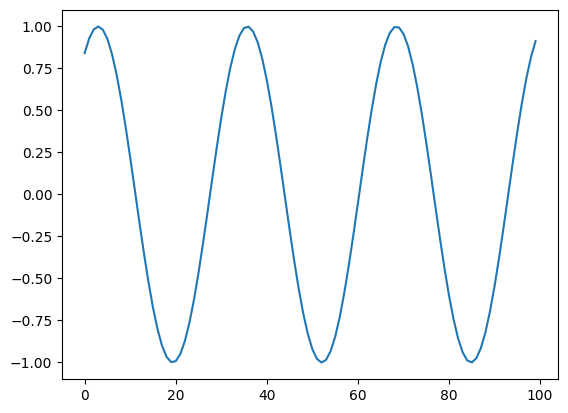

In [ ]:
plot(np.sin(linspace(1,20,100)))

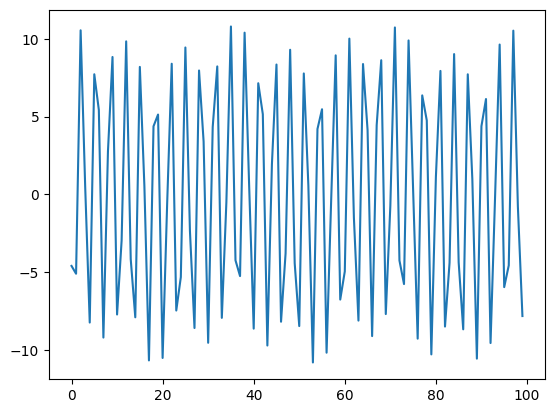

In [ ]:
plot(np.sin(linspace(1,20,100))+10*np.sin(10*linspace(1,20,100)))

In [ ]:
!pip install utide

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
from utide import solve, reconstruct

/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


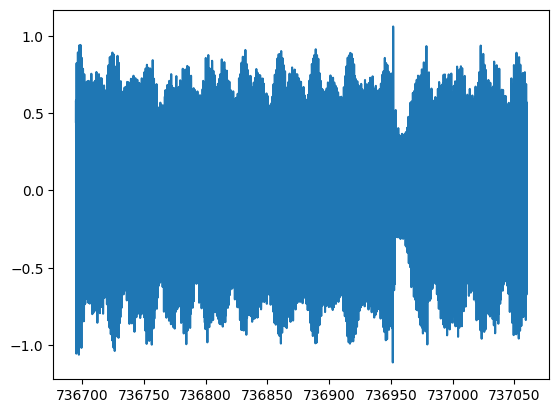

In [ ]:
fp=(msl.station==8658120)*(msl.time>=datenum(2018,1,1))*(msl.time<datenum(2019,1,1))
oti,oyi=msl.time[fp],msl.elev[fp]
#oyi=oyi-oyi.mean()
oyi=oyi-lpfilt(oyi,1/24,0.4)

#xts,xls=get_xtick(fmt=2,xts=[datenum(2018,1,1),datenum(2019,1,1)],str=4)
plot(oti,oyi)
#setp(gca(),xticks=xts,xticklabels=xls,xlim=[datenum(2018,2,1),datenum(2018,2,10)]);


In [ ]:
print(oti)

[736695.         736695.04166667 736695.08333333 ... 737059.875
 737059.91666667 737059.95833333]


solve: matrix prep ... solution ... done.
DatetimeIndex(['2018-01-03 00:00:00', '2018-01-03 01:00:00',
               '2018-01-03 02:00:00', '2018-01-03 03:00:00',
               '2018-01-03 04:00:00', '2018-01-03 05:00:00',
               '2018-01-03 06:00:00', '2018-01-03 07:00:00',
               '2018-01-03 08:00:00', '2018-01-03 09:00:00',
               ...
               '2018-01-23 10:00:00', '2018-01-23 11:00:00',
               '2018-01-23 12:00:00', '2018-01-23 13:00:00',
               '2018-01-23 14:00:00', '2018-01-23 15:00:00',
               '2018-01-23 16:00:00', '2018-01-23 17:00:00',
               '2018-01-23 18:00:00', '2018-01-23 19:00:00'],
              dtype='datetime64[ns]', length=500, freq='H')
prep/calcs ... done.


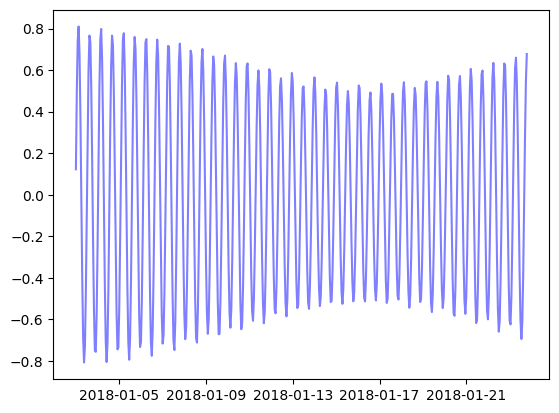

In [ ]:
coef=solve(oti,oyi,lat=34.2,nodal='False',trend='False',
               epoch='python',method='ols',conf_int='linear',Rayleigh_min=0.95)
# takes tidal elev observations and solves for harmonic analysis (separates constituents)
#print(coef)

N=500
from pandas import date_range
t=date_range(start="2018-01-03",periods=N,freq="H")
print(t)
tide=reconstruct(t,coef,constit=['M2','N2','S1'])
#tide=reconstruct(t,coef)

#plot(oti,oyi,'r')
plot(t,tide['h'],alpha=0.5,label='Modeled M2',color="b")


In [ ]:
print(coef)

A       : [6.38425218e-01 1.36494319e-01 8.53147132e-02 8.20867650e-02
 6.25522763e-02 5.56373454e-02 4.39212916e-02 3.17195761e-02
 3.04066944e-02 2.99945921e-02 2.90439146e-02 2.62794859e-02
 2.32442379e-02 2.32202026e-02 2.29343389e-02 2.21315733e-02
 2.01161975e-02 1.98214163e-02 1.96115695e-02 1.95912814e-02
 1.84292709e-02 1.74484986e-02 1.57188851e-02 1.40661873e-02
 1.30216374e-02 1.03383648e-02 9.28646828e-03 8.81309518e-03
 8.01131391e-03 7.90733736e-03 7.80715539e-03 7.18093795e-03
 6.45229890e-03 6.18639053e-03 5.97505903e-03 5.49590550e-03
 5.39087710e-03 5.37471771e-03 5.31709986e-03 5.18294842e-03
 4.99629740e-03 4.67018681e-03 4.59886640e-03 4.34957753e-03
 4.32360900e-03 4.13026897e-03 3.75519116e-03 3.19038775e-03
 3.08367122e-03 2.84860383e-03 2.28366089e-03 2.26176290e-03
 1.93011154e-03 1.82842262e-03 1.40559611e-03 9.87943798e-04
 9.18736283e-04 8.87504940e-04 7.98916146e-04 6.49791704e-04
 5.04535919e-04 4.08284170e-04 3.56452016e-04 2.75765289e-04
 2.41829967e-0

# **Excercise**
Do harmonic analysis for station 8654467, and predict tidal elevation in January 2023.

solve: matrix prep ... solution ... done.
DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-02-11 06:00:00', '2023-02-11 07:00:00',
               '2023-02-11 08:00:00', '2023-02-11 09:00:00',
               '2023-02-11 10:00:00', '2023-02-11 11:00:00',
               '2023-02-11 12:00:00', '2023-02-11 13:00:00',
               '2023-02-11 14:00:00', '2023-02-11 15:00:00'],
              dtype='datetime64[ns]', length=1000, freq='H')
prep/calcs ... done.


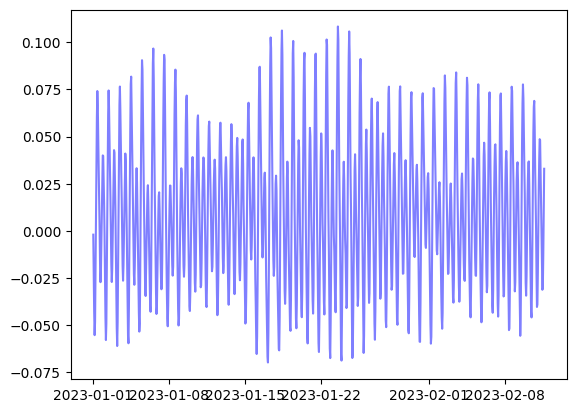

In [ ]:
fp=(msl.station==8654467)*(msl.time>=datenum(2018,1,1))*(msl.time<datenum(2019,1,1))
oti,oyi=msl.time[fp],msl.elev[fp]
#oyi=oyi-oyi.mean()
oyi=oyi-lpfilt(oyi,1/24,0.4)
#plot(oti,oyi)

coef=solve(oti,oyi,lat=34.2,nodal='False',trend='False',
               epoch='python',method='ols',conf_int='linear',Rayleigh_min=0.95)
# takes tidal elev observations and solves for harmonic analysis (separates constituents)
#print(coef)

N=1000
from pandas import date_range
t=date_range(start="2023-01-01",periods=N,freq="H")
print(t)
#tide=reconstruct(t,coef,constit='M2')
tide=reconstruct(t,coef)

#plot(oti,oyi,'r')
plot(t,tide['h'],alpha=0.5,label='Modeled M2',color="b")